In [7]:
import pandas as pd
import numpy as np
import sys,os
import matplotlib.pyplot as plt
import utils
import concurrent.futures
import importlib
import seaborn as sns

In [8]:

# CIFAR ICML experiments
target_dir = "my_results/icml_experiments/cifar10/"

#CIFAR Additional runs with seeds:
# target_dir = "my_results/icml_experiments/additional_cifar10/"

# Tryouts for Femnist
# target_dir = "my_results/test/testing_femnist_convergence_rates/"

#Tryouts for CIFAR
# target_dir = "my_results/test/testing_convergence_rates/"

TOTAL_PROCESSES = 128
MAX_MACHINES =  8
MAX_ITERATIONS=10000
STARTING_ITERATION = 0

linestyles = {
    "ZeroSum" : "--"
}

fontsize=20

alpha = 0.1

save_directory = "assets/"

ORDERINGS = {
    "noise_level" : ["nonoise","1th","2th","4th","8th","16th","32th","64th","128th"],
    "variant":["nonoise","zerosum","muffliato"],
    "avgsteps": ["10avgsteps", "1avgsteps"]
} 

assert TOTAL_PROCESSES%MAX_MACHINES == 0
MAX_PROCESSES = TOTAL_PROCESSES//MAX_MACHINES

In [9]:
# Load the file list
experiments_dict = utils.get_full_path_dict(target_dir)
experiments_attributes = utils.get_experiments_dict(experiments_dict)

print(experiments_attributes)

{'2069890_muffliato_static_128nodes_10avgsteps_32th': {'network_size': '128nodes', 'topology_type': 'static', 'variant': 'muffliato', 'avgsteps': '10avgsteps', 'additional_attribute': 'muffliato', 'noise_level': '32th', 'lr': None, 'local_rounds': None, 'batch_size': None, 'seed': None}, '2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th': {'network_size': '128nodes', 'topology_type': 'static', 'variant': 'zerosum', 'avgsteps': '1avgsteps', 'additional_attribute': 'selfnoise', 'noise_level': '2th', 'lr': None, 'local_rounds': None, 'batch_size': None, 'seed': None}, '2079616_muffliato_static_128nodes_1avgsteps_2th': {'network_size': '128nodes', 'topology_type': 'static', 'variant': 'muffliato', 'avgsteps': '1avgsteps', 'additional_attribute': 'muffliato', 'noise_level': '2th', 'lr': None, 'local_rounds': None, 'batch_size': None, 'seed': None}, '2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th': {'network_size': '128nodes', 'topology_type': 'static', 'variant': 'zerosum',

In [11]:
machine_folder = 'machine{}'
result_file = '{}_results.json'


def load_data(dir):
    data = pd.DataFrame({})
    for machine in range(MAX_MACHINES):
        for rank in range(MAX_PROCESSES):
            # print(f"Loading results for machine {machine} and rank {rank}.  ",end = "\r")
            uid = rank + machine * MAX_PROCESSES

            file = os.path.join(dir, machine_folder.format(machine), result_file.format(rank))
            tmp_df = pd.read_json(file)
            tmp_df["uid"] = uid # Manually add the uid for further processing                                                                   
            tmp_df["iteration"] = tmp_df.index
            # print(tmp_df)
            tmp_df = tmp_df[tmp_df["iteration"]>=STARTING_ITERATION]
            tmp_df = tmp_df[tmp_df["iteration"]<=MAX_ITERATIONS]
            data = pd.concat([data,tmp_df])
    return data

def load_attack_results(current_experiment_data,experiment_dir):
    experiment_name = os.path.basename(experiment_dir)
    expected_file_name = "threshold_" + experiment_name + ".csv"
    directories = sorted(os.listdir(experiment_dir))
    
    if expected_file_name not in directories:
        print(f"Not loading attack results: {expected_file_name} was not listed with attack results in {experiment_dir}. Entire directory:\n{directories}")
        return current_experiment_data
    attacks_df = pd.read_csv(os.path.join(experiment_dir,expected_file_name))
    attacks_df = attacks_df.drop(columns = "Unnamed: 0")
    attacks_df = attacks_df.rename(columns = {"agent":"uid"})
    # print(attacks_df.columns)
    # print(current_experiment_data)
    # print(attacks_df)
    
    res = pd.merge(current_experiment_data, attacks_df,on = ["uid","iteration"],how="outer" )
    # print(res)
    return res

def load_linkability_attack_results(current_experiment_data,experiment_dir):
    experiment_name = os.path.basename(experiment_dir)
    expected_file_name = f"linkability_{experiment_name}.csv"
    directories = sorted(os.listdir(experiment_dir))
    if expected_file_name not in directories:
        print(f"Not loading attack results: {expected_file_name} was not listed with attack results in {experiment_dir}. Entire directory:\n{directories}")
        return current_experiment_data
    
    linkability_attack_df = pd.read_csv(os.path.join(experiment_dir,expected_file_name))

    linkability_attack_df = linkability_attack_df.rename(columns = {"agent":"uid"})

    return pd.merge(current_experiment_data,linkability_attack_df,on = ["uid","iteration"],how="outer")

# Function to recompute some of the linkability attack results. Should only be used if there are errors in the data (see perform_attack.py).
def fix_linkability_attack_results(experiment_name,attack_results_path):
    expected_file_name = f"linkability_{experiment_name}.csv"
    directories = sorted(os.listdir(attack_results_path))
    if expected_file_name not in directories:
        print(f"Not loading attack results: {expected_file_name} was not listed with attack results in {attack_results_path}. Entire directory:\n{directories}")
        raise FileNotFoundError(expected_file_name)
    
    linkability_attack_df = pd.read_csv(os.path.join(attack_results_path,expected_file_name))
    
    # Fixing all the missing values/wrongly filled values  
    linkability_attack_df["linkability_top1"] = (linkability_attack_df["linkability_top1_guess"]==linkability_attack_df["agent"])
    
    linkability_attack_df.reset_index(drop = True)
    linkability_attack_df.set_index(["agent","iteration"])
    columns = linkability_attack_df.columns.to_list()
    columns_losses = [column for column in columns if "loss_trainset_" in column]
    
    linkability_attack_df["linkability_real_rank"] = np.nan
    linkability_attack_df["linkability_real_rank"].astype('Int64',copy=False)
    for index,row in linkability_attack_df.iterrows():
        losses = [(int(column.split("_")[2]),row[column]) for column in columns_losses]
        losses_sorted = sorted(losses, key = lambda x:x[1])
        agents_sorted = [x[0] for x in losses_sorted]
        current_agent = row["agent"]
        linkability_rank = agents_sorted.index(current_agent)
        linkability_attack_df.at[index,"linkability_real_rank"] = linkability_rank
    
    linkability_attack_df = linkability_attack_df.drop(columns = "Unnamed: 0")
    linkability_attack_df.to_csv(os.path.join(attack_results_path,f"fixed_{expected_file_name}"))
    
    return linkability_attack_df

def load_data_element(experiment_dir):
    name = os.path.basename(experiment_dir)
    print(f"Loading data from {name}")
    current_results = load_data(experiment_dir).dropna()
    current_results = load_attack_results(current_results,experiment_dir)
    current_results = load_linkability_attack_results(current_results,experiment_dir)
    # input_dict[name] = current_results
    attributes = utils.get_attributes(name)
    for attribute, attribute_value in attributes.items():
        current_results[attribute] = attribute_value
    
    print(f"Finished loading data from {name}")
    return current_results


loaded_data = {}

with concurrent.futures.ProcessPoolExecutor(max_workers=20) as executor:
    futures = {}
    for name,filepath in sorted(experiments_dict.items()):
        # load_data_element(loaded_data,filepath)
        # break
    
        futures[name] = executor.submit(load_data_element,filepath)
        
        
        # fix_linkability_attack_results(name,attack_results_path=ATTACK_RESULTS_PATH)
        # break
    for name, result in futures.items():
        loaded_data[name]=result.result()
# print(loaded_data)
print("Finished loading all data")

Loading data from 2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3roundsLoading data from 2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16thLoading data from 2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2thLoading data from 2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4thLoading data from 2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3roundsLoading data from 2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
Loading data from 2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32thLoading data from 2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th


Loading data from 2067675_zerosum_selfnoise_dynamic_128nodes_1avgsteps_8th

Loading data from 2067678_zerosum_selfnoise_dynamic_128nodes_1avgsteps_32thLoading data from 2067680_zerosum_selfnoise_dynamic_128nodes_1avgsteps_64thLoading data from 2067677_zerosum_selfnoise_dynamic_128nodes_1avgsteps_16thLoading data from 2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4thLoading data fr

In [ ]:
general_agg_methods = ["mean", "std", "sum","min","max"]
columns_to_agg = ["train_loss","test_loss", "test_acc", "total_bytes", "total_meta", "total_data_per_n", "roc_auc"]
# columns_to_agg = ["train_loss","test_loss", "test_acc", "total_bytes", "total_meta", "total_data_per_n"]


def count_percentage_success(column:pd.Series):
    counts = column.value_counts(normalize=True)
    if True not in counts:
        return np.nan
    res = counts[True]
    return res 


linkability_aggregators = {
    "linkability_top1": [count_percentage_success],
    "linkability_top5": [count_percentage_success],
    "linkability_real_rank": ["median","min","max"],
}

def start_avg(column:pd.Series):
    res = []
    running_elements:pd.Series = pd.Series({})
    for (index,value) in column.items():
        if np.isnan(value):
            res.append(np.NaN)
        elif running_elements.empty:
            running_elements = pd.Series(value)
            res.append(value)
        else:
            running_elements = pd.concat([running_elements,pd.Series(value)])
            res.append(running_elements.mean()) 
    return res

to_start_avg = ["roc_auc mean","linkability_top1 count_percentage_success"]

general_aggregator = {column:general_agg_methods for column in columns_to_agg}

general_aggregator.update(linkability_aggregators) 

def format_data(data,key):
    usable_data = data[["iteration"] + columns_to_agg +  list(linkability_aggregators.keys())]
    grouped_data = usable_data.groupby(['iteration']) 
    usable_data = grouped_data.agg(general_aggregator)
    usable_data.reset_index(inplace=True)
    usable_data.set_index("iteration",inplace=True)

    usable_data.insert(1,"experience_name",key)
    usable_data.insert(2,"number_agents",TOTAL_PROCESSES)

    usable_data.columns = [' '.join(e) if len(e[-1])>0 else e[0] for e in usable_data.columns]

    
    
    experiment_attributes = utils.get_attributes(key)
    for attribute, attribute_value in experiment_attributes.items():
        usable_data[attribute] = attribute_value
    
    # Compute an additional column: "{column}_start_avg"
    for column_name in to_start_avg:
        rolled_average = start_avg(usable_data[column_name])
        usable_data[column_name + "_start_avg"] =  rolled_average
        print(usable_data[column_name + "_start_avg"].dropna() )
    return usable_data



formatted_data = {}
for name,data in sorted(loaded_data.items()):
    print(f"Formatting {name}")
    formatted_data[name] = format_data(data,name)
formatted_data[list(formatted_data)[0]].columns

Formatting 2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
iteration
500      0.860758
1000     0.853828
1500     0.854177
2000     0.853242
2500     0.853191
3000     0.853083
3500     0.851631
4000     0.851585
4500     0.850805
5000     0.849864
5500     0.848166
6000     0.846854
6500     0.844995
7000     0.842957
7500     0.841355
8000     0.839692
8500     0.837931
9000     0.835588
9500     0.833456
10000    0.830935
Name: roc_auc mean_start_avg, dtype: float64
iteration
500      0.296875
1000     0.308594
1500     0.341146
2000     0.373047
2500     0.398438
3000     0.434896
3500     0.458705
4000     0.490234
4500     0.515625
5000     0.544531
5500     0.571023
6000     0.599609
6500     0.623197
7000     0.645089
7500     0.658333
8000     0.666992
8500     0.677849
9000     0.691406
9500     0.698191
10000    0.710156
Name: linkability_top1 count_percentage_success_start_avg, dtype: float64
Formatting 2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0

Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max',
       'test_acc mean', 'test_acc std', 'test_acc sum', 'test_acc min',
       'test_acc max', 'total_bytes mean', 'total_bytes std',
       'total_bytes sum', 'total_bytes min', 'total_bytes max',
       'total_meta mean', 'total_meta std', 'total_meta sum', 'total_meta min',
       'total_meta max', 'total_data_per_n mean', 'total_data_per_n std',
       'total_data_per_n sum', 'total_data_per_n min', 'total_data_per_n max',
       'roc_auc mean', 'roc_auc std', 'roc_auc sum', 'roc_auc min',
       'roc_auc max', 'linkability_top1 count_percentage_success',
       'linkability_top5 count_percentage_success',
       'linkability_real_rank median', 'linkability_real_rank min',
       'linkability_real_rank max', 'network_size', 'topology_type', 'variant',


Saving to assets/All_experiments_accuracies_evolution.pdf


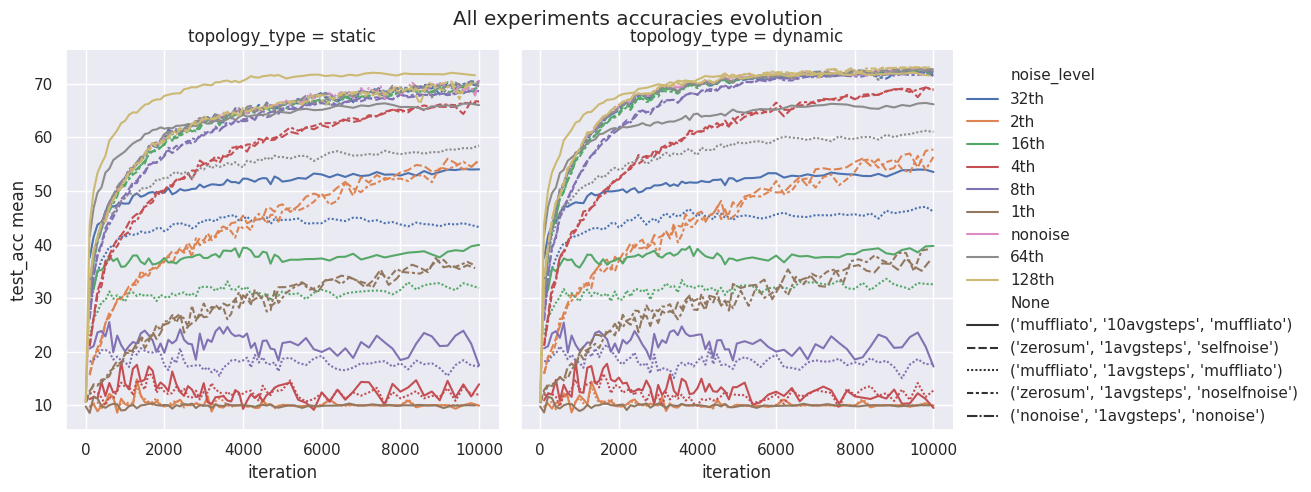

In [ ]:
importlib.reload(utils)
static_filter = {"topology_type" : ["static"] }
dynamic_filter = {"topology_type" : ["dynamic"]}

static_experiments =  utils.filter_attribute(experiments_attributes,static_filter)
dynamic_experiments = utils.filter_attribute(experiments_attributes,dynamic_filter)

#To display full experiments
display_attributes = {
    "hue": "noise_level",
    "style":["variant","avgsteps","additional_attribute"],
    "col" : "topology_type",
}

# To display experiment parameters tuning.
# display_attributes = {
#     "hue": "lr",
#     "style":"local_rounds",
#     "col" : "topology_type",
# }

utils.plot_all_experiments(
    formatted_data,
    experiments_attributes,
    display_attributes,
    "All experiments accuracies evolution",
    "test_acc mean",
    save_directory=save_directory
)


## Noise cancellation vs no noise cancellation

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
2067675_zerosum_selfnoise_dynamic_128nodes_1avgsteps_8th
2067677_zerosum_selfnoise_dynamic_128nodes_1avgsteps_16th
2067678_zerosum_selfnoise_dynamic_128nodes_1avgsteps_32th
2067680_zerosum_selfnoise_dynamic_128nodes_1avgsteps_64th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2068746_zerosum_selfnoise_dynamic_128nodes_1avgsteps_2th
2068748_zerosum_noselfnoise_static_128nodes_1avgsteps_2th
2068753_zerosum_noselfnoise_static_128nodes_1avgsteps_4th
2068754_zerosum_noselfnoise_static_128nodes_1avgsteps_8th
2068755_zer

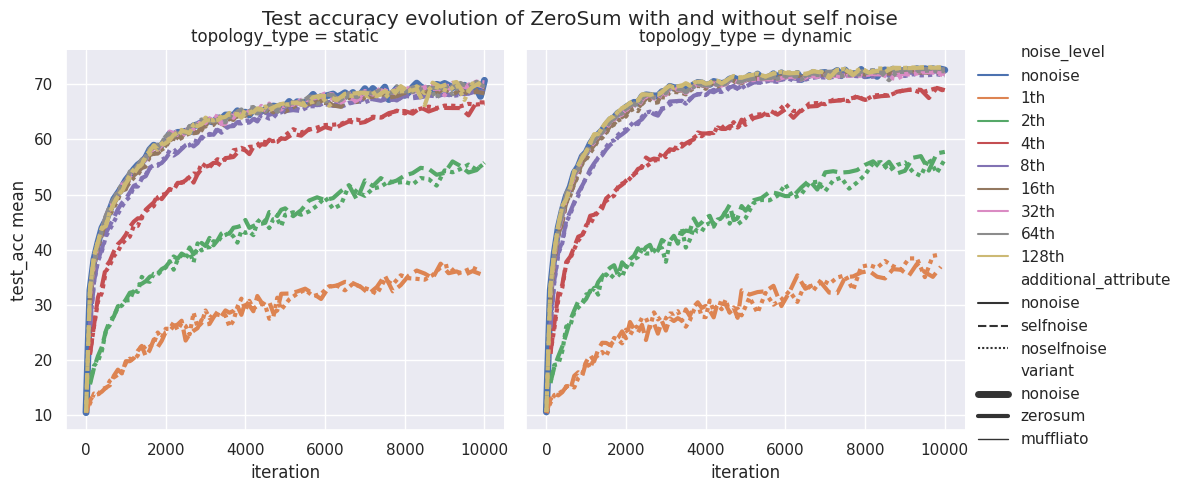

In [ ]:

importlib.reload(utils)
zerosum_attributes = {"variant":["nonoise","zerosum"]}
# zerosum_attributes = {"variant":["nonoise","zerosum"],"topology_type":["static"]}
# zerosum_attributes = {"variant":["nonoise","zerosum"],"topology_type":["dynamic"]}

display_attributes = {
    "hue":"noise_level",
    "style": "additional_attribute",
    "size": "variant",
    "col":"topology_type"
}

zerosum_experiments = utils.filter_attribute(experiments_attributes,zerosum_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Test accuracy evolution of ZeroSum with and without self noise",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)



# Attack results
## In the static case:

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
2067675_zerosum_selfnoise_dynamic_128nodes_1avgsteps_8th
2067677_zerosum_selfnoise_dynamic_128nodes_1avgsteps_16th
2067678_zerosum_selfnoise_dynamic_128nodes_1avgsteps_32th
2067680_zerosum_selfnoise_dynamic_128nodes_1avgsteps_64th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2068746_zerosum_selfnoise_dynamic_128nodes_1avgsteps_2th
2068748_zerosum_noselfnoise_static_128nodes_1avgsteps_2th
2068753_zerosum_noselfnoise_static_128nodes_1avgsteps_4th
2068754_zerosum_noselfnoise_static_128nodes_1avgsteps_8th
2068755_zer

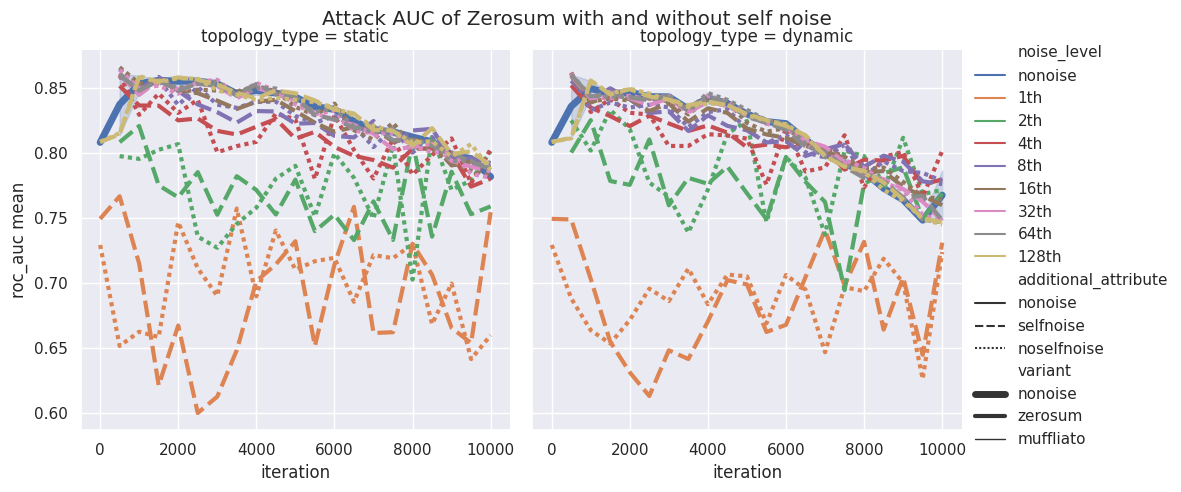

In [ ]:
importlib.reload(utils)
zerosum_attributes = {"variant":["nonoise","zerosum"]}
# zerosum_attributes = {"variant":["nonoise","zerosum"],"topology_type":["static"]}
# zerosum_attributes = {"variant":["nonoise","zerosum"],"topology_type":["dynamic"]}

display_attributes = {
    "hue":"noise_level",
    "style": "additional_attribute",
    "size": "variant",
    "col": "topology_type",
}

zerosum_experiments = utils.filter_attribute(experiments_attributes,zerosum_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Attack AUC of Zerosum with and without self noise",
    "roc_auc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

# Results vs Muffliato

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
2067675_zerosum_selfnoise_dynamic_128nodes_1avgsteps_8th
2067677_zerosum_selfnoise_dynamic_128nodes_1avgsteps_16th
2067678_zerosum_selfnoise_dynamic_128nodes_1avgsteps_32th
2067680_zerosum_selfnoise_dynamic_128nodes_1avgsteps_64th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2068746_zerosum_selfnoise_dynamic_128nodes_1avgsteps_2th
2069875_muffliato_static_128nodes_10avgsteps_2th
2069886_muffliato_static_128nodes_10avgsteps_4th
2069887_muffliato_static_128nodes_10avgsteps_8th
2069889_muffliato_static_128nodes_10av

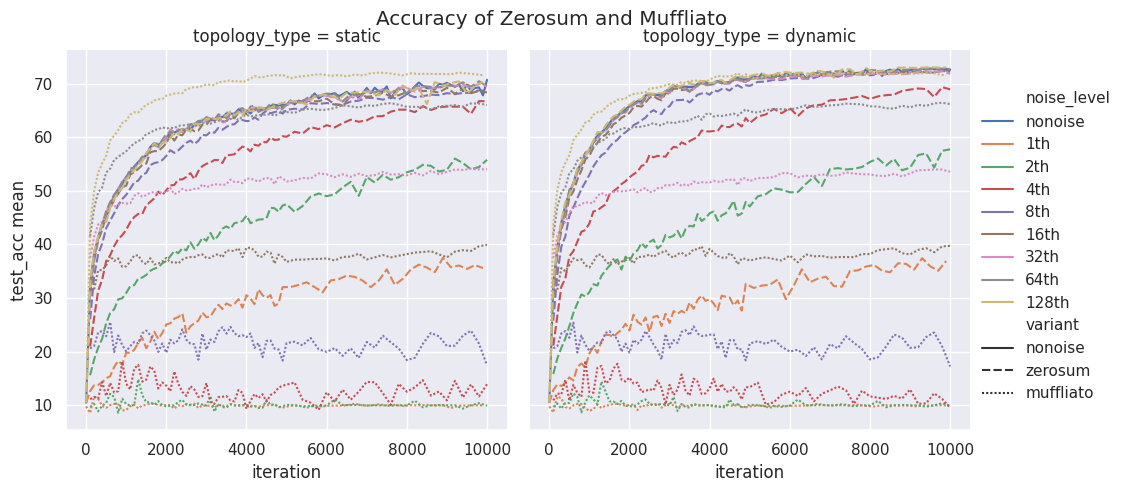

<Figure size 640x480 with 0 Axes>

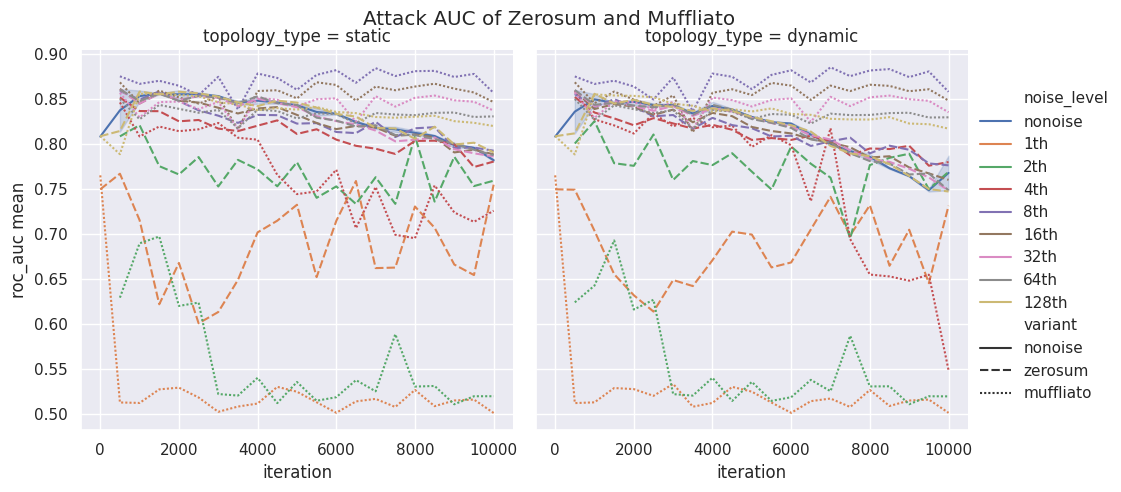

In [ ]:
importlib.reload(utils)

zerosum_attributes = {
    "variant":["zerosum","nonoise"],
    # "topology_type":["static"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"],
    # "avgsteps": ["1avgsteps","10avgsteps"],
    "additional_attribute": ["nonoise","selfnoise"]}
muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["static"],
    # "topology_type":["dynamic"],
    "avgsteps":["10avgsteps"],
}

current_attributes= [zerosum_attributes,muffliato_attributes]

display_attributes = {
    "hue":"noise_level",
    "style":"variant",
    # "size":"variant", # For some reason having both style and size breaks in this case.
    "col":"topology_type",
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)


utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Accuracy of Zerosum and Muffliato",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Attack AUC of Zerosum and Muffliato",
    "roc_auc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

### Smaller plots to have an easier time to read the information

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2068746_zerosum_selfnoise_dynamic_128nodes_1avgsteps_2th
2069875_muffliato_static_128nodes_10avgsteps_2th
2069886_muffliato_static_128nodes_10avgsteps_4th
2069893_muffliato_dynamic_128nodes_10avgsteps_2th
2069895_muffliato_dynamic_128nodes_10avgsteps_4th
2094445_zerosum_selfnoise_128nodes_1avgsteps_1th_static_seed90
2094452_zerosum_selfnoise_128nodes_1avgsteps_1th_dynamic_seed90
2094634_muffliato_128nodes_10avgsteps_1th_static_seed90
2094635_muffliato_128nodes_10avgsteps_1th_dynamic_seed90
4443235_nonoise_128nodes_1avgsteps_dynamic_seed90
4443409_nonoise_128nodes_1avgsteps_static_seed90
Saving to assets/High_noise:Accuracy_of_Zerosum_and_Muffliato_with_and_without_self_noise.pdf
Saving to as

(0.7411237500351626, 1.0)

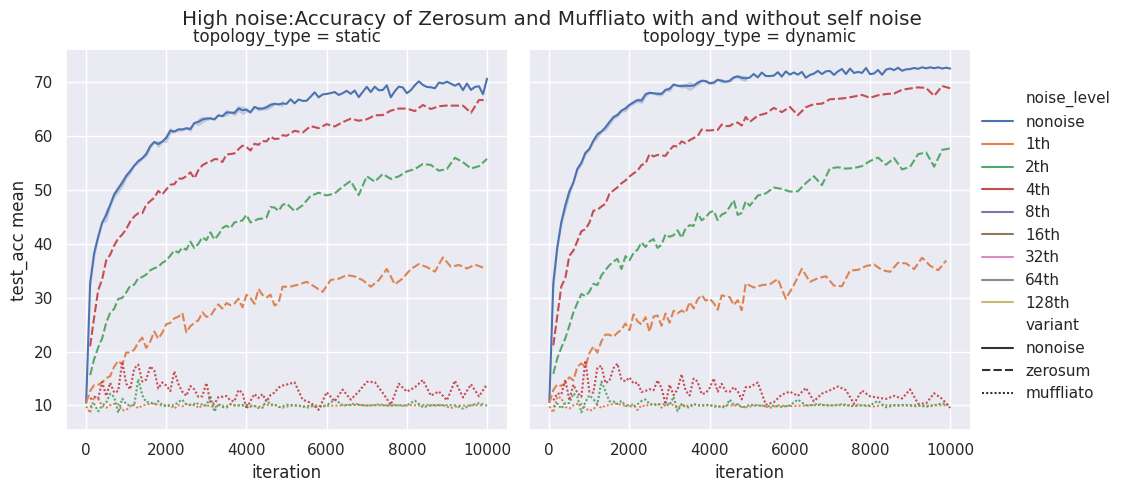

<Figure size 640x480 with 0 Axes>

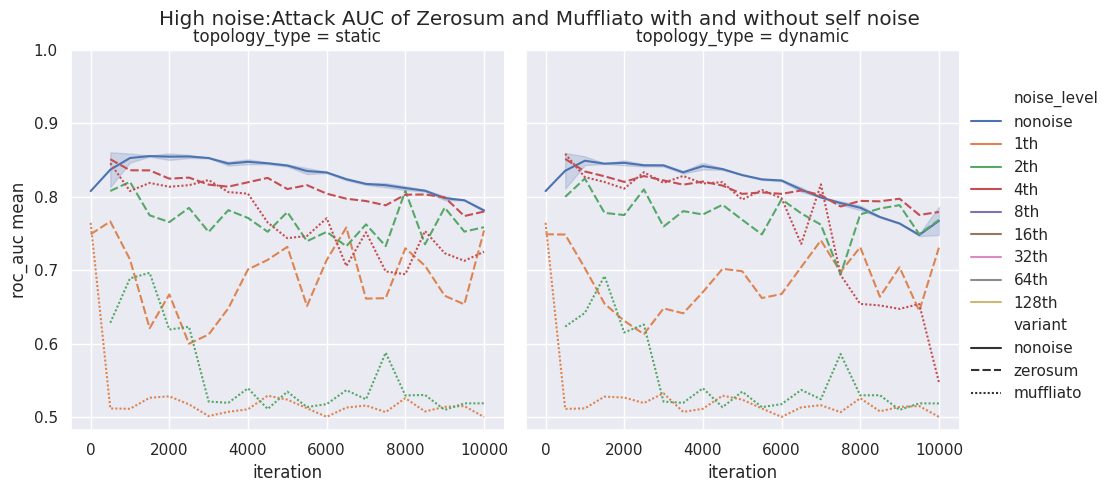

<Figure size 640x480 with 0 Axes>

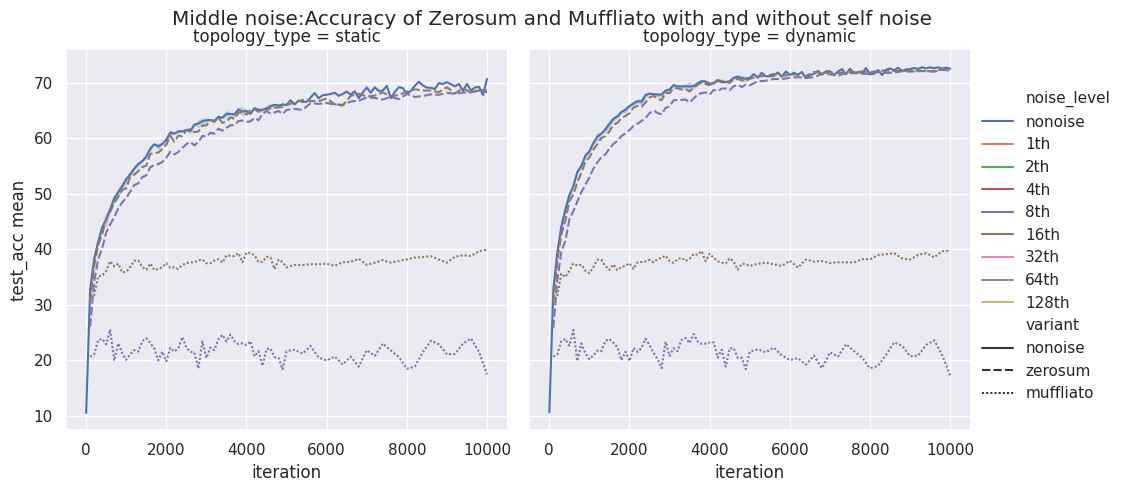

<Figure size 640x480 with 0 Axes>

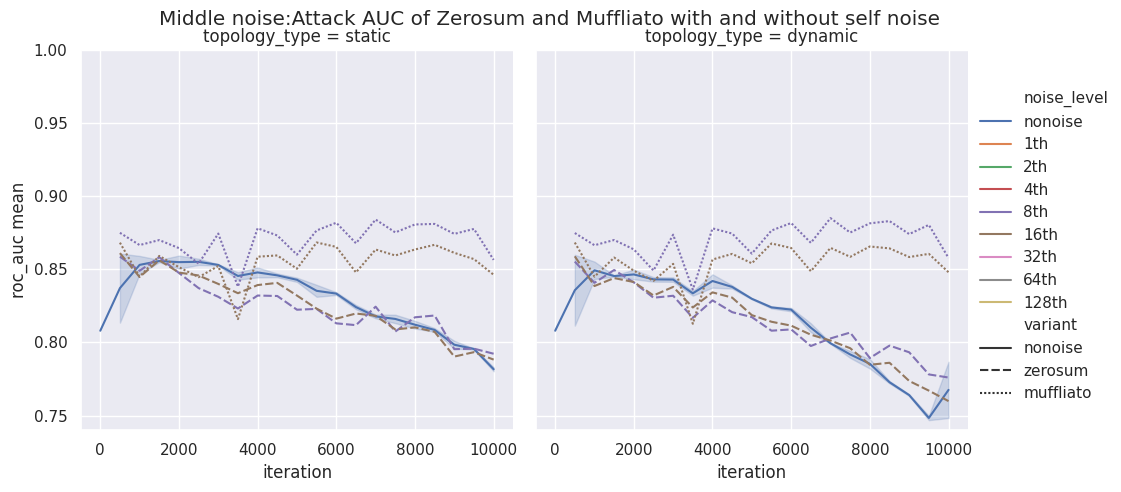

<Figure size 640x480 with 0 Axes>

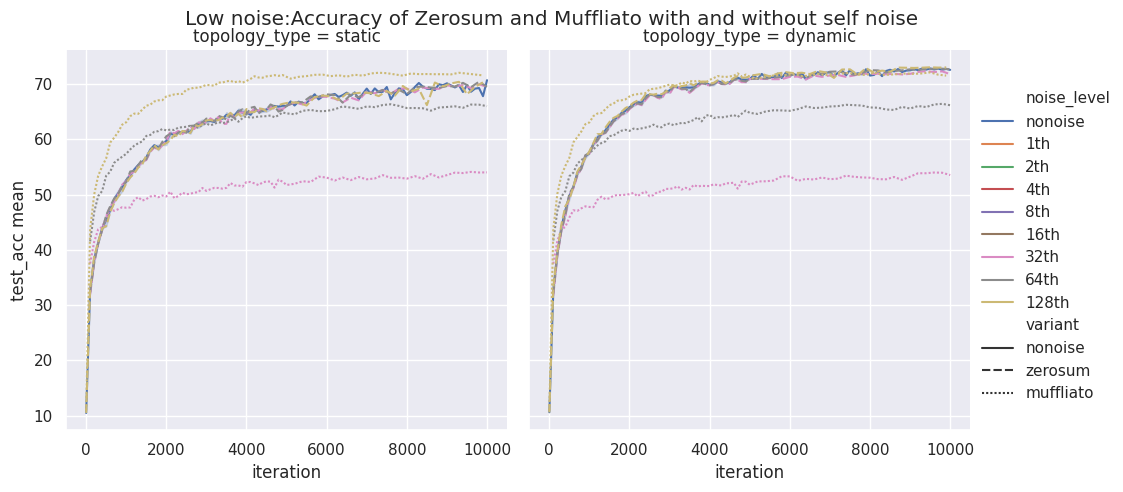

<Figure size 640x480 with 0 Axes>

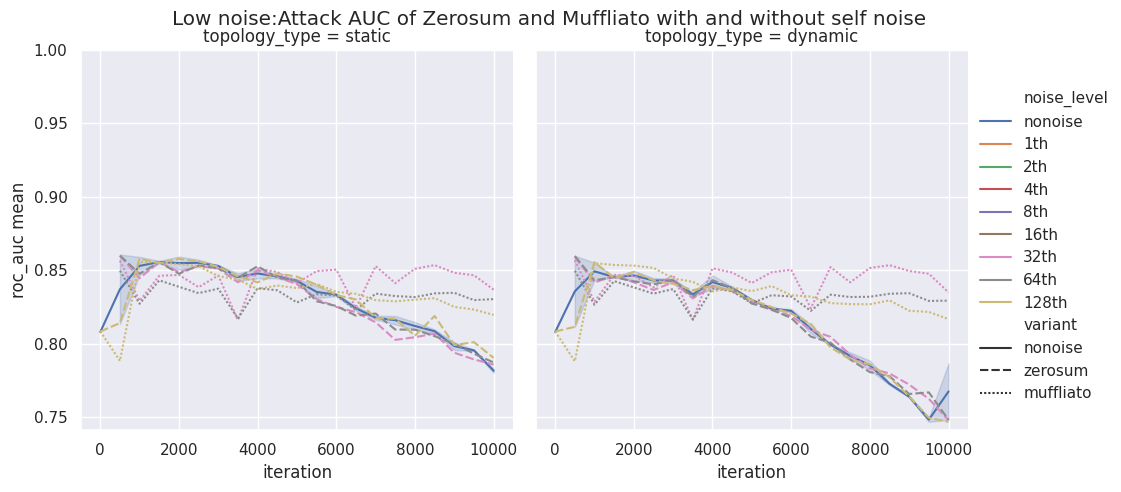

In [ ]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","1th","2th","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["1th","2th","4th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]


display_attributes = {
    "hue":"noise_level",
    "style":"variant",
    # "size":"variant", # For some reason having both style and size breaks in this case.
    "col":"topology_type",
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)



utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "High noise:Accuracy of Zerosum and Muffliato with and without self noise",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "High noise:Attack AUC of Zerosum and Muffliato with and without self noise",
    "roc_auc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)
plt.ylim(top=1)

# Plot the middle noises
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","8th","16th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["8th","16th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.figure()
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Middle noise:Accuracy of Zerosum and Muffliato with and without self noise",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Middle noise:Attack AUC of Zerosum and Muffliato with and without self noise",
    "roc_auc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)
plt.ylim(top=1)

# Plot the low noises
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","32th","64th","128th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["32th","64th","128th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.figure()
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Low noise:Accuracy of Zerosum and Muffliato with and without self noise",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Low noise:Attack AUC of Zerosum and Muffliato with and without self noise",
    "roc_auc mean",
    save_directory=save_directory,
    orderings=ORDERINGS
)
plt.ylim(top=1)



# Trying out scatterplots

## Aggregated plots:

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
2069875_muffliato_static_128nodes_10avgsteps_2th
2069886_muffliato_static_128nodes_10avgsteps_4th
2069887_muffliato_static_128nodes_10avgsteps_8th
2069889_muffliato_static_128nodes_10avgsteps_16th
2069890_muffliato_static_128nodes_10avgsteps_32th
2069891_muffliato_static_128nodes_10avgsteps_64th
2094445_zerosum_selfnoise_128nodes_1avgsteps_1th_static_seed90
2094451_zerosum_selfnoise_128nodes_1avgsteps_128th_static_seed90
2094632_muffliato_128nodes_10avgsteps_128th_static_seed90
2094634_muffliato_128nodes_10avgsteps_1th_static_seed90
4443409_nonoise_128nodes_1avgsteps_static_seed90
   noise

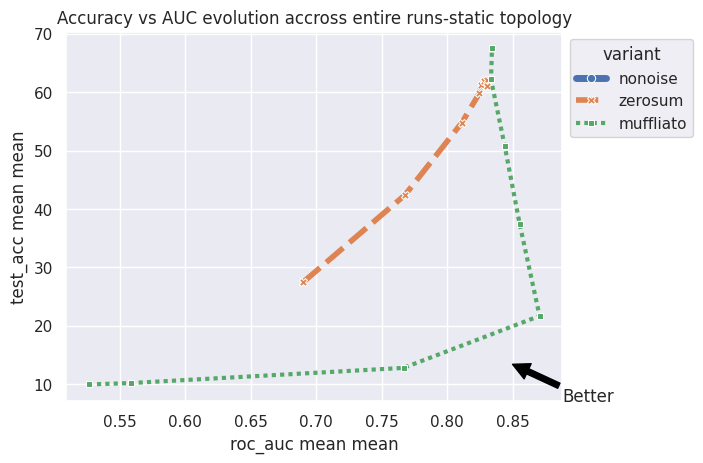

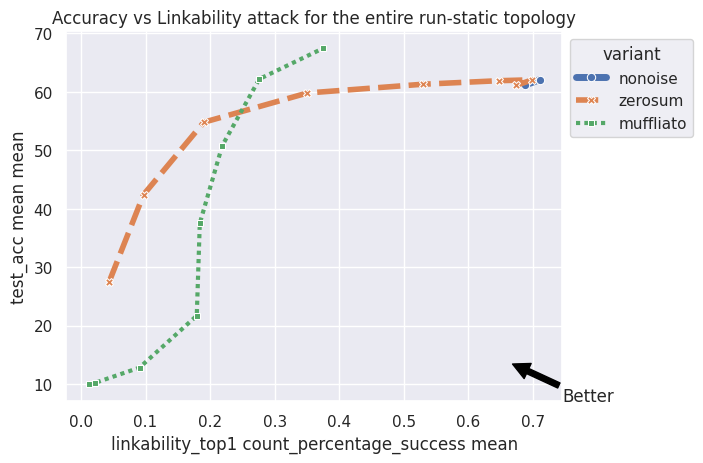

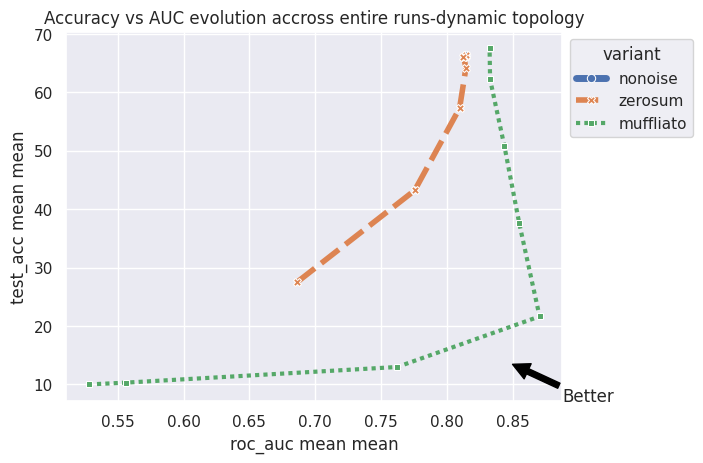

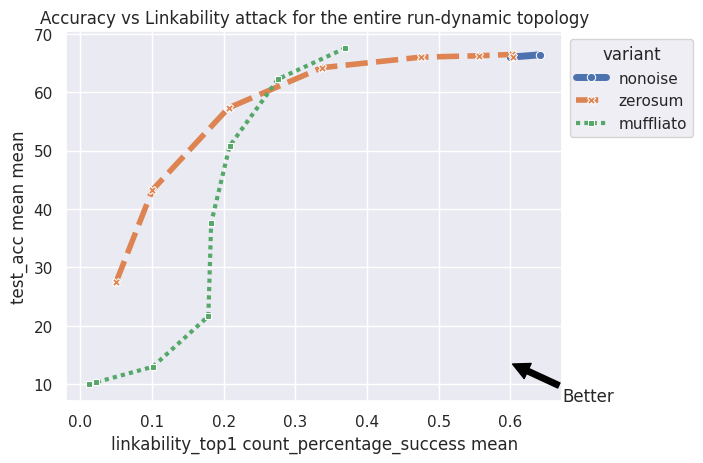

In [ ]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["10avgsteps"],
}

current_attributes = [zerosum_attributes,muffliato_attributes]

display_attributes = {
    "hue":"variant",
    "style":"variant",
    "size":"variant", # For some reason having both style and size breaks in this case.
    # "col":"topology_type",# Cannot have col argument for the lineplot function
}
zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)


utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Accuracy vs AUC evolution accross entire runs-static topology",
    "test_acc mean",
    "roc_auc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)
plt.figure()


utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Accuracy vs Linkability attack for the entire run-static topology",
    "test_acc mean",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"],
}
current_attributes = [zerosum_attributes,muffliato_attributes]
zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.figure()
utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Accuracy vs AUC evolution accross entire runs-dynamic topology",
    "test_acc mean",
    "roc_auc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)
plt.figure()


utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Accuracy vs Linkability attack for the entire run-dynamic topology",
    "test_acc mean",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

Same plots, but with the maxes instead!

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
2069875_muffliato_static_128nodes_10avgsteps_2th
2069886_muffliato_static_128nodes_10avgsteps_4th
2069887_muffliato_static_128nodes_10avgsteps_8th
2069889_muffliato_static_128nodes_10avgsteps_16th
2069890_muffliato_static_128nodes_10avgsteps_32th
2069891_muffliato_static_128nodes_10avgsteps_64th
2094445_zerosum_selfnoise_128nodes_1avgsteps_1th_static_seed90
2094451_zerosum_selfnoise_128nodes_1avgsteps_128th_static_seed90
2094632_muffliato_128nodes_10avgsteps_128th_static_seed90
2094634_muffliato_128nodes_10avgsteps_1th_static_seed90
4443409_nonoise_128nodes_1avgsteps_static_seed90
   noise

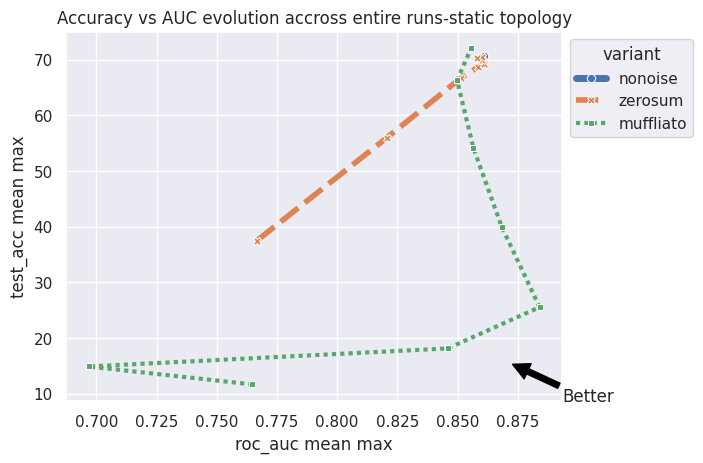

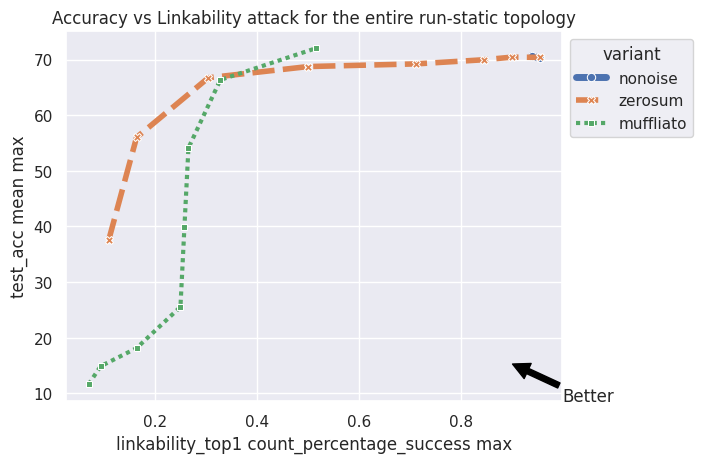

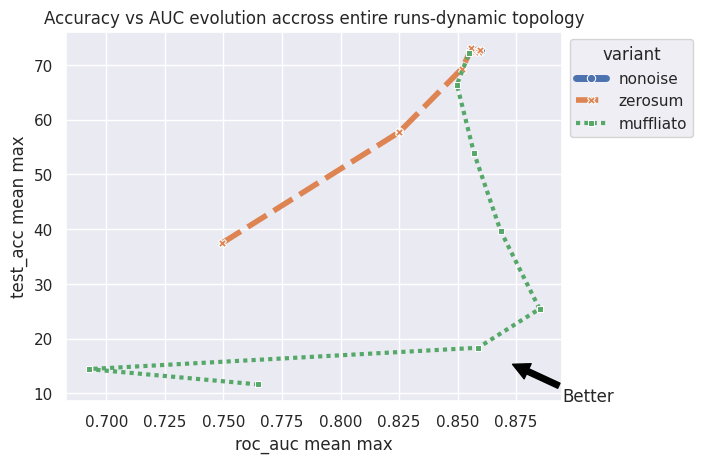

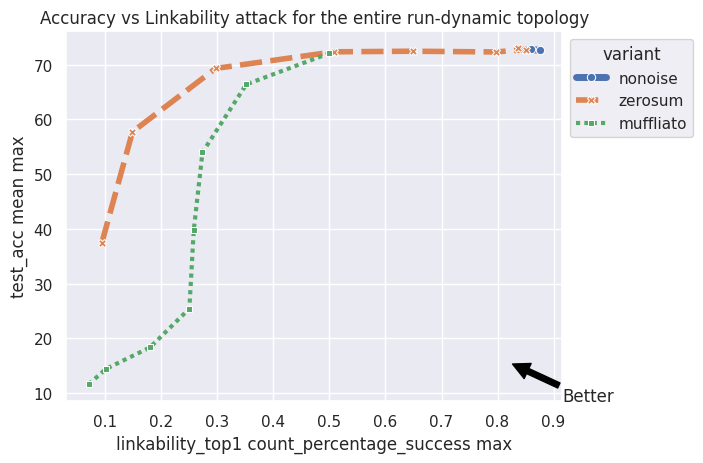

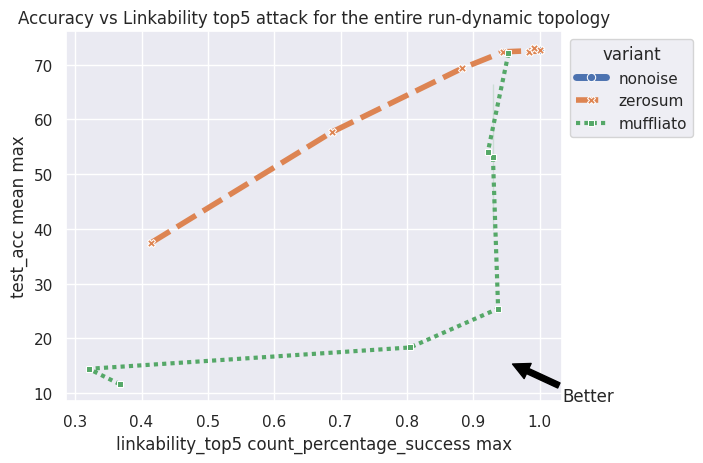

In [ ]:
importlib.reload(utils)
x_method = "max"
y_method = "max"

zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["10avgsteps"],
}

current_attributes = [zerosum_attributes,muffliato_attributes]

display_attributes = {
    "hue":"variant",
    "style":"variant",
    "size":"variant", # For some reason having both style and size breaks in this case.
    # "col":"topology_type",# Cannot have col argument for the lineplot function
}
zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)


utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Accuracy vs AUC evolution accross entire runs-static topology",
    "test_acc mean",
    "roc_auc mean",
    save_directory=save_directory,
    y_method=y_method,
    x_method=x_method,
    orderings=ORDERINGS,
)
plt.figure()


utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Accuracy vs Linkability attack for the entire run-static topology",
    "test_acc mean",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    y_method=y_method,
    x_method=x_method,
    orderings=ORDERINGS,
)

zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"],
}
current_attributes = [zerosum_attributes,muffliato_attributes]
zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.figure()
utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Accuracy vs AUC evolution accross entire runs-dynamic topology",
    "test_acc mean",
    "roc_auc mean",
    save_directory=save_directory,
    y_method=y_method,
    x_method=x_method,
    orderings=ORDERINGS,
)
plt.figure()


utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Accuracy vs Linkability attack for the entire run-dynamic topology",
    y_axis_name="test_acc mean",
    x_axis_name="linkability_top1 count_percentage_success",
    save_directory=save_directory,
    y_method=y_method,
    x_method=x_method,
    orderings=ORDERINGS,
)

plt.figure()

utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Accuracy vs Linkability top5 attack for the entire run-dynamic topology",
    y_axis_name="test_acc mean",
    x_axis_name="linkability_top5 count_percentage_success",
    save_directory=save_directory,
    y_method=y_method,
    x_method=x_method,
    orderings=ORDERINGS,
)

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
4443409_nonoise_128nodes_1avgsteps_static_seed90


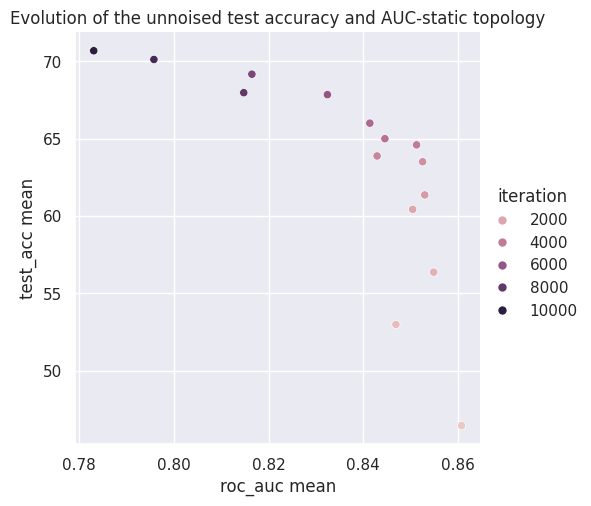

In [ ]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"],
    # "noise_level":[None,"2th","4th"]
}


zerosum_experiments = utils.filter_attribute(experiments_attributes,zerosum_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)


experiment = zerosum_experiments[0]
experiment_data = formatted_data[experiment] 

sns.set_theme()
sns.relplot(data=experiment_data, x="roc_auc mean", y="test_acc mean", hue="iteration")

title = "Evolution of the unnoised test accuracy and AUC-static topology"
plt.title(title)
plt.savefig(save_directory + title.replace(" ","_") +".pdf")

## Better experiment display (selected noises levels)

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2069891_muffliato_static_128nodes_10avgsteps_64th
2069899_muffliato_dynamic_128nodes_10avgsteps_64th
4443235_nonoise_128nodes_1avgsteps_dynamic_seed90
4443409_nonoise_128nodes_1avgsteps_static_seed90
Saving to assets/Selected_noise:Accuracy_of_Zerosum_and_Muffliato.pdf
Saving to assets/Selected_noise:Attack_AUC_of_Zerosum_and_Muffliato.pdf
Saving to assets/Selected_noise:Linkability_attack_ac_of_Zerosum_and_Muffliato.pdf
2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2069891_muffliato_static_128nodes_10avgsteps_64th
4443409_nonoise_128nodes_1avgsteps_static_seed90
----------------------------------------
Saving to assets/Selected_noise:Accuracy_vs_AUC-static.pdf
Saving to a

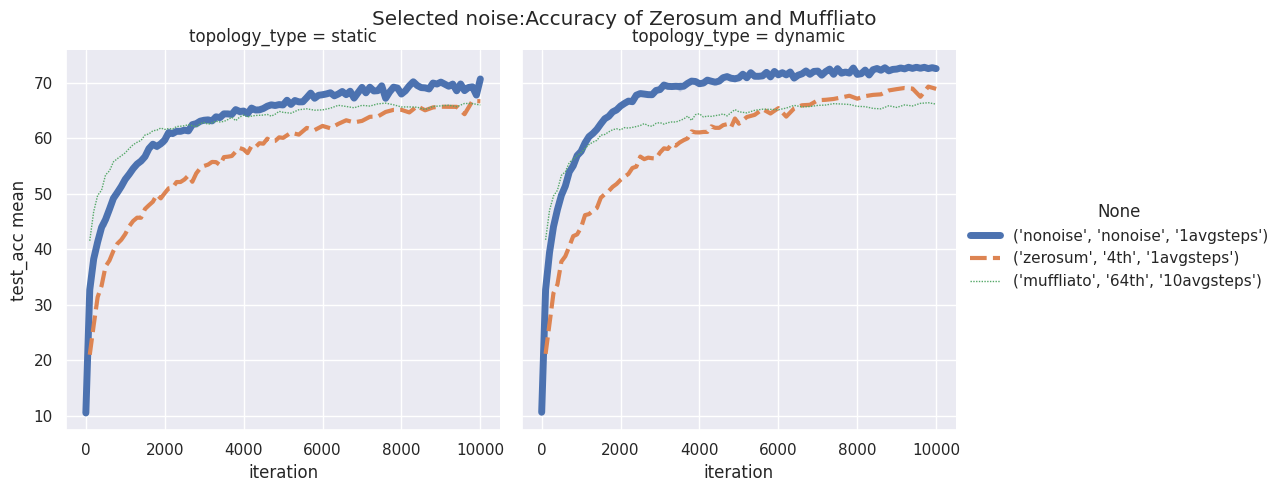

<Figure size 640x480 with 0 Axes>

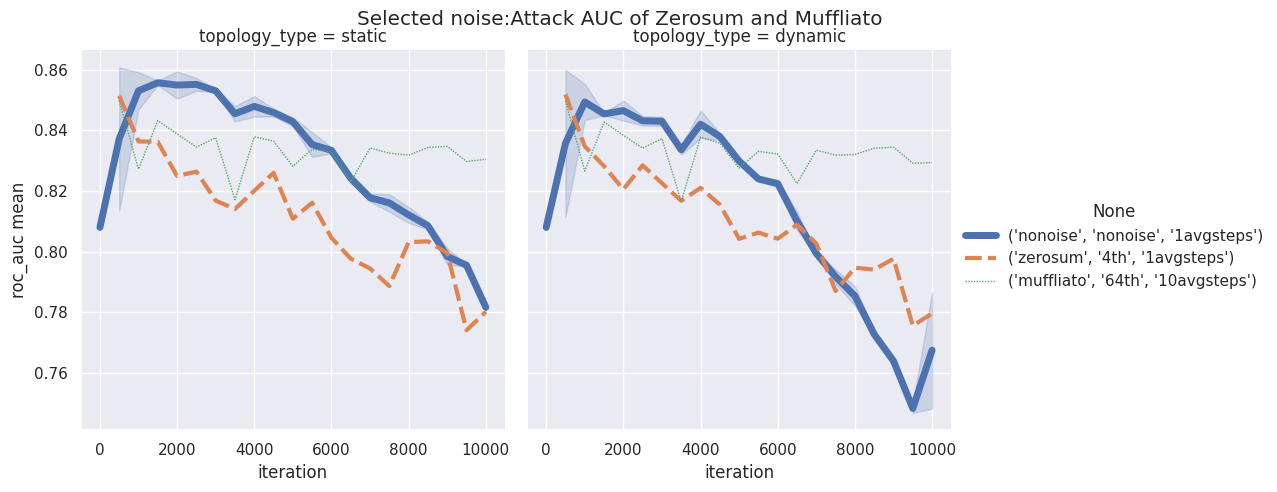

<Figure size 640x480 with 0 Axes>

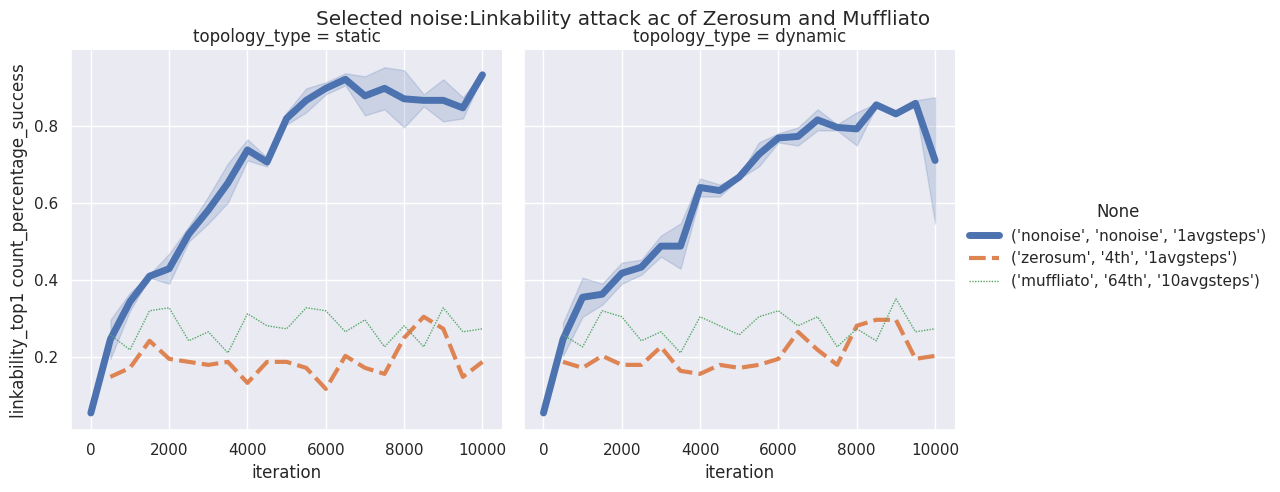

<Figure size 640x480 with 0 Axes>

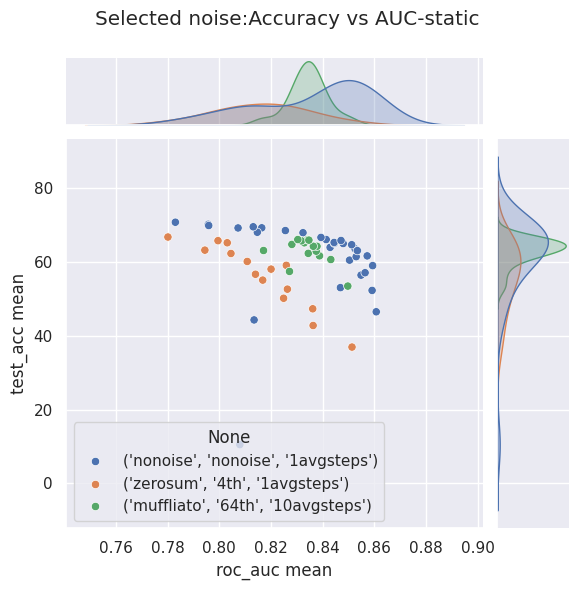

<Figure size 640x480 with 0 Axes>

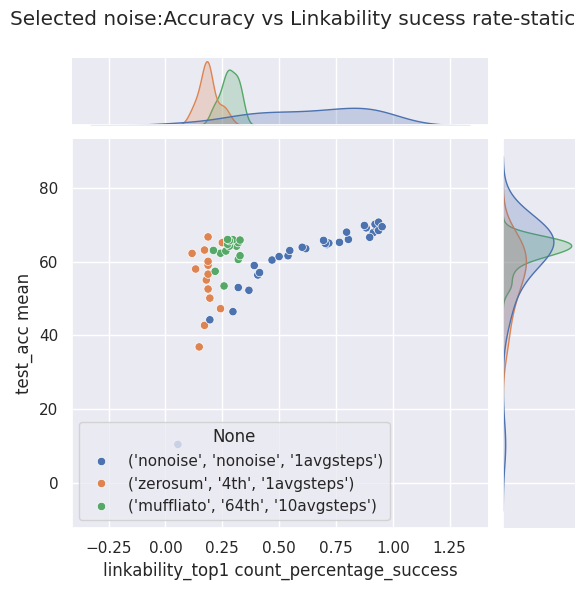

In [ ]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

display_attributes = {
    "hue":["variant","noise_level","avgsteps"],
    "style":["variant","noise_level","avgsteps"],
    "size":["variant","noise_level","avgsteps"], # For some reason having both style and size breaks in this case.
    "col":"topology_type",
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)
# zerosum_experiments = [zerosum_experiments[i] for i in [0,1,4,5,2,3] ]



utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Accuracy of Zerosum and Muffliato",
    "test_acc mean",
    save_directory=save_directory,
    orderings = ORDERINGS,
)


plt.figure()

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Attack AUC of Zerosum and Muffliato",
    "roc_auc mean",
    save_directory=save_directory,
    orderings = ORDERINGS,
)

plt.figure()

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Linkability attack ac of Zerosum and Muffliato",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    orderings = ORDERINGS,
)

plt.figure()

#Needs to only have hue since we can't have other attributes in jointplots
display_attributes = {
    "hue":["variant","noise_level","avgsteps"],
}

zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)
print("-"*40)


utils.scatter_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Accuracy vs AUC-static",
    "roc_auc mean",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)
plt.figure()
utils.scatter_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Accuracy vs Linkability sucess rate-static",
    "linkability_top1 count_percentage_success",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2068746_zerosum_selfnoise_dynamic_128nodes_1avgsteps_2th
2069875_muffliato_static_128nodes_10avgsteps_2th
2069886_muffliato_static_128nodes_10avgsteps_4th
2069893_muffliato_dynamic_128nodes_10avgsteps_2th
2069895_muffliato_dynamic_128nodes_10avgsteps_4th
2094445_zerosum_selfnoise_128nodes_1avgsteps_1th_static_seed90
2094452_zerosum_selfnoise_128nodes_1avgsteps_1th_dynamic_seed90
2094634_muffliato_128nodes_10avgsteps_1th_static_seed90
2094635_muffliato_128nodes_10avgsteps_1th_dynamic_seed90
4443235_nonoise_128nodes_1avgsteps_dynamic_seed90
4443409_nonoise_128nodes_1avgsteps_static_seed90
Saving to assets/High_noise:Accuracy_of_Zerosum_and_Muffliato_with_and_without_self_noise-dynamic_topology

(0.009765625, 1.0)

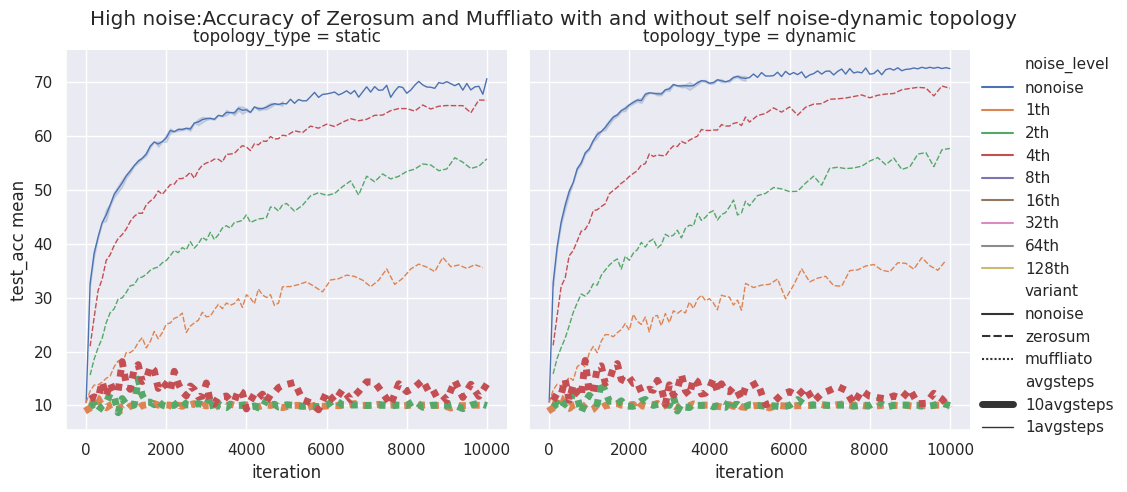

<Figure size 640x480 with 0 Axes>

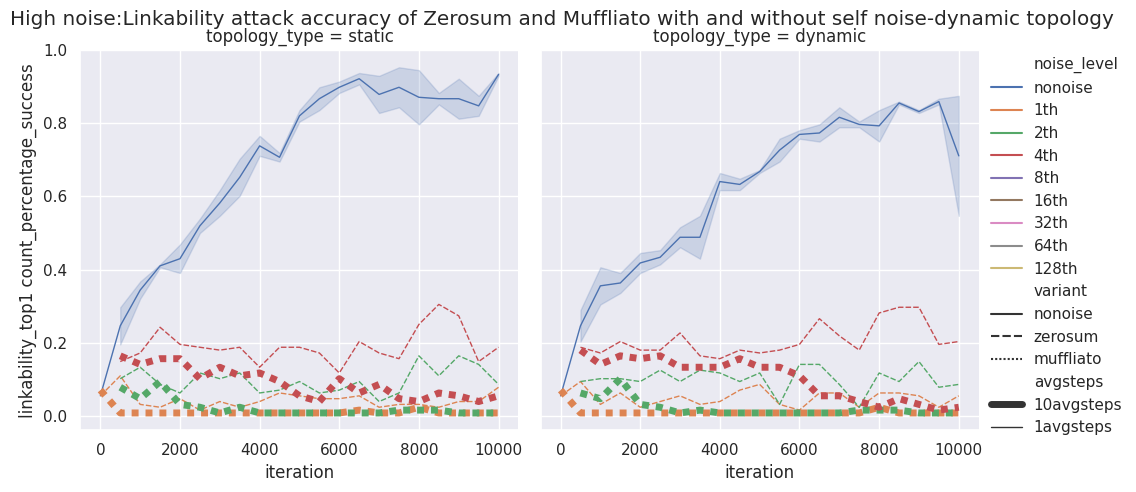

<Figure size 640x480 with 0 Axes>

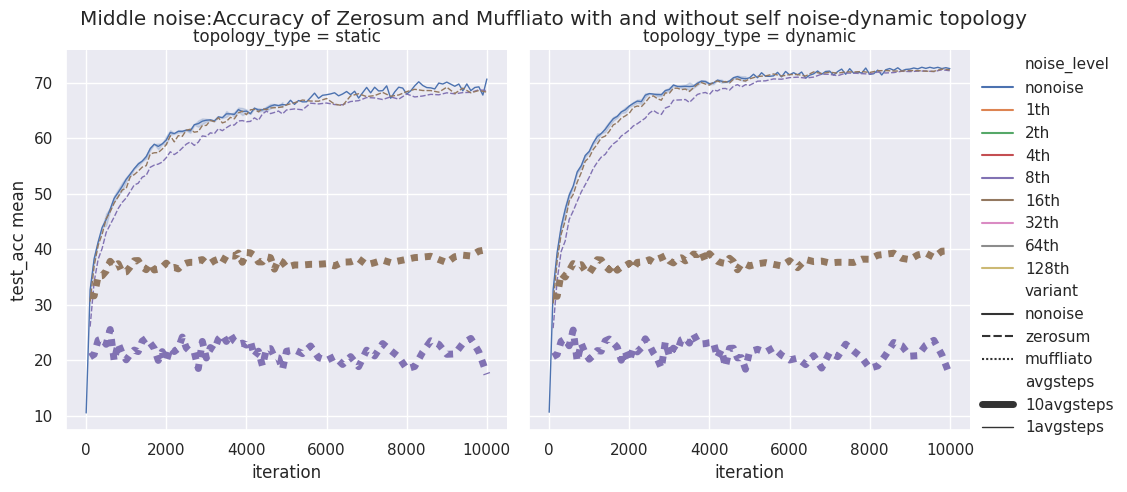

<Figure size 640x480 with 0 Axes>

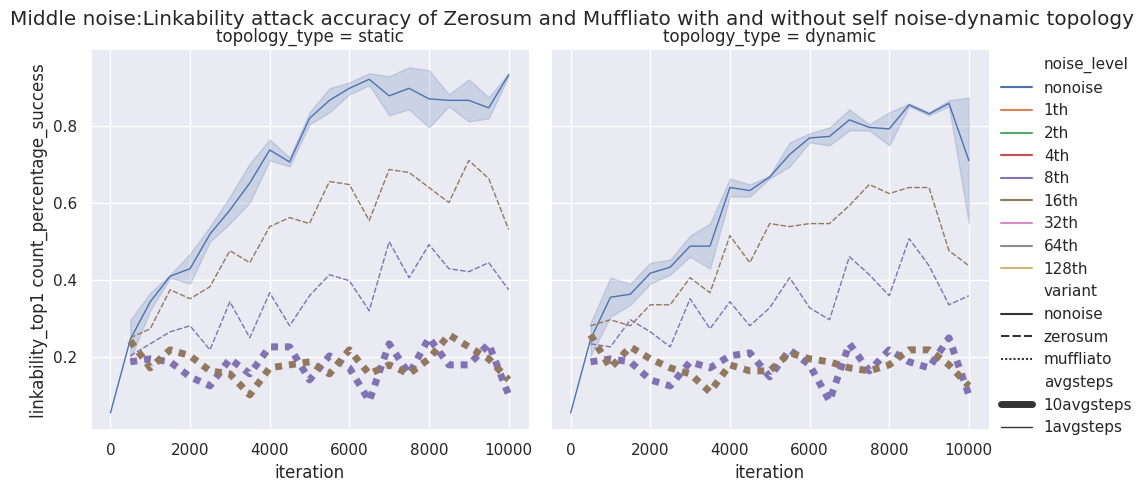

<Figure size 640x480 with 0 Axes>

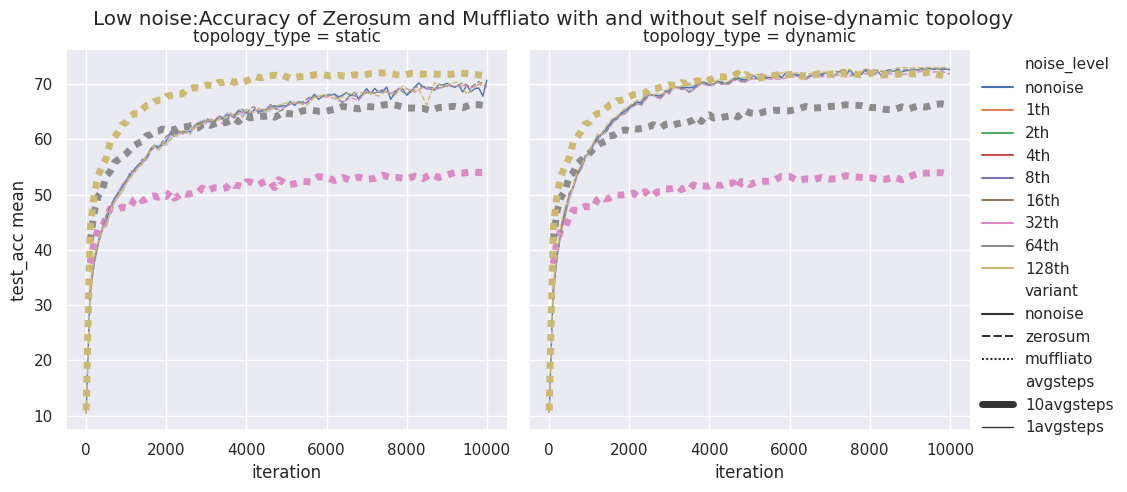

<Figure size 640x480 with 0 Axes>

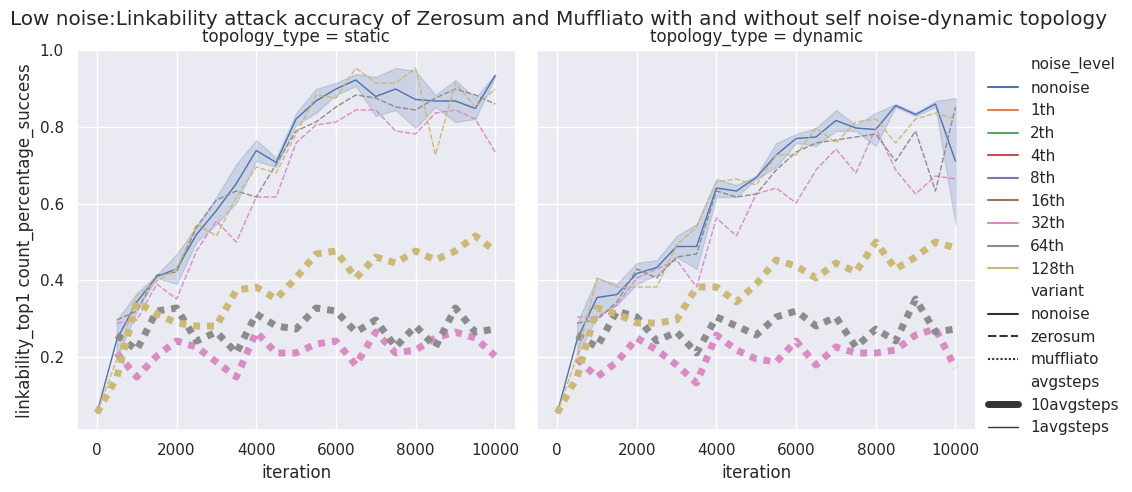

In [ ]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","1th","2th","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["1th","2th","4th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]


display_attributes = {
    "hue":"noise_level",
    "style":"variant",
    "size":"avgsteps", # For some reason having both style and size breaks in this case.
    "col":"topology_type",
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)



utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "High noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "High noise:Linkability attack accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

# Plot the middle noises
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","8th","16th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["8th","16th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.figure()
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Middle noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Middle noise:Linkability attack accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    orderings=ORDERINGS,
)


# Plot the low noises
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","32th","64th","128th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["32th","64th","128th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.figure()
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Low noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Low noise:Linkability attack accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    orderings=ORDERINGS,
)
plt.ylim(top=1)



# Start average trial displays

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2069891_muffliato_static_128nodes_10avgsteps_64th
2069899_muffliato_dynamic_128nodes_10avgsteps_64th
4443235_nonoise_128nodes_1avgsteps_dynamic_seed90
4443409_nonoise_128nodes_1avgsteps_static_seed90
Saving to assets/Selected_noise:Accuracy_of_Zerosum_and_Muffliato.pdf
Saving to assets/Selected_noise:Attack_AUC_rolling_average_of_Zerosum_and_Muffliato.pdf
Saving to assets/Selected_noise:Linkability_attack_rolling_average_ac_of_Zerosum_and_Muffliato.pdf
2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2069891_muffliato_static_128nodes_10avgsteps_64th
4443409_nonoise_128nodes_1avgsteps_static_seed90
----------------------------------------
Saving to assets/Selected_noise:Accura

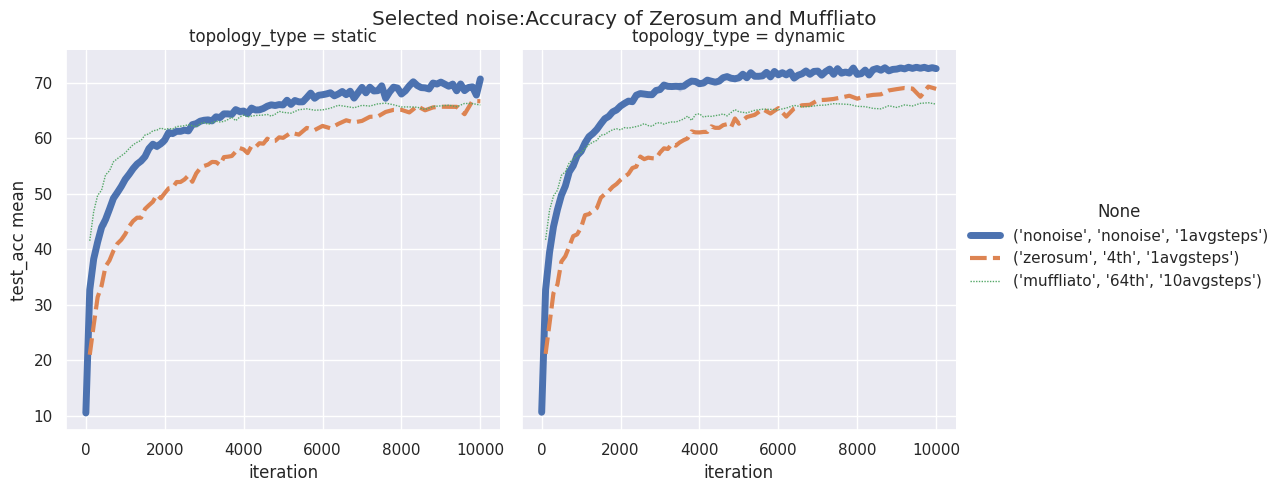

<Figure size 640x480 with 0 Axes>

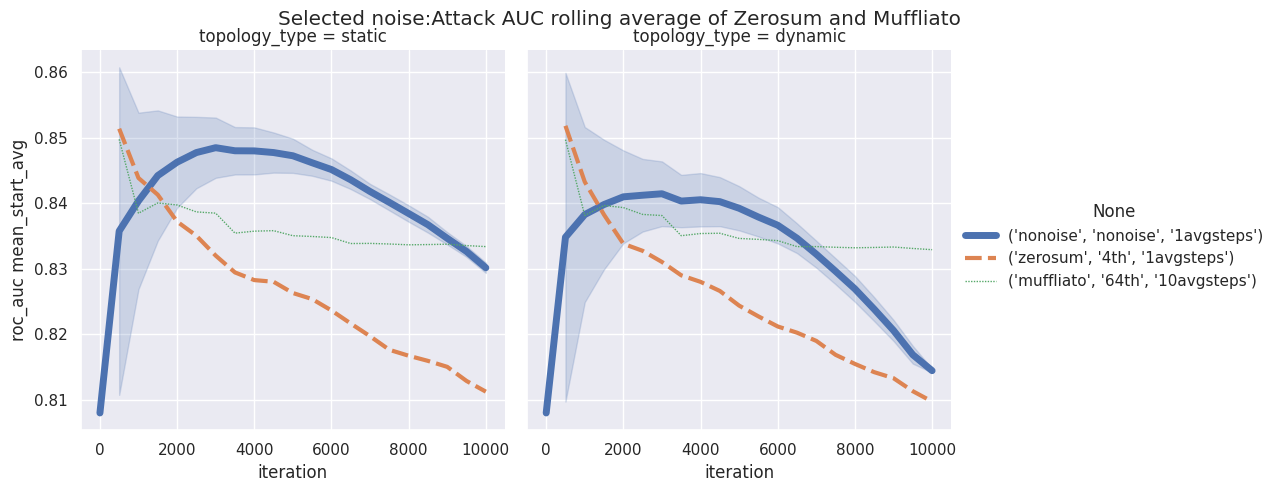

<Figure size 640x480 with 0 Axes>

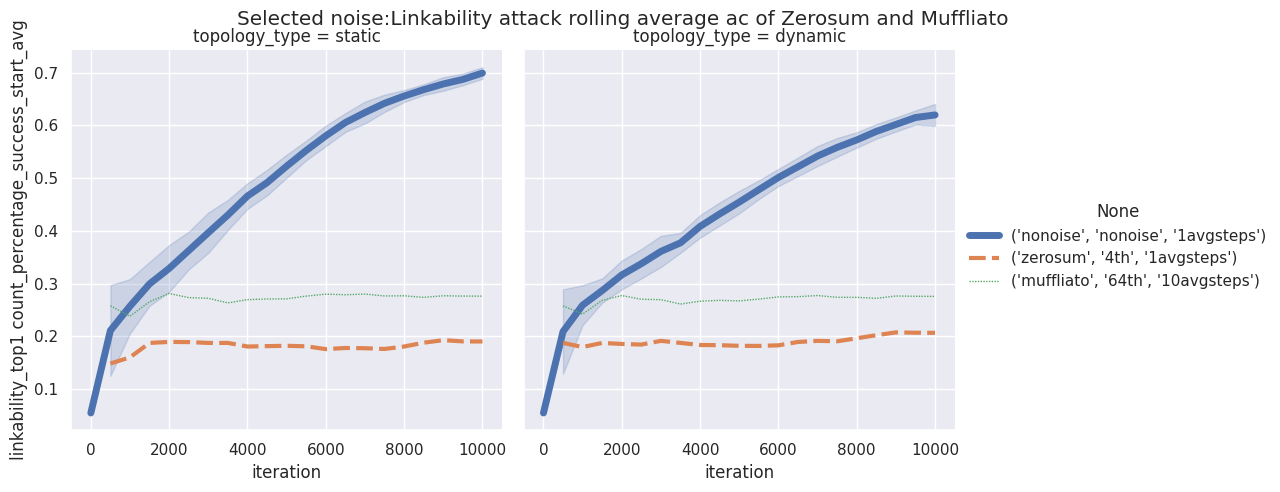

<Figure size 640x480 with 0 Axes>

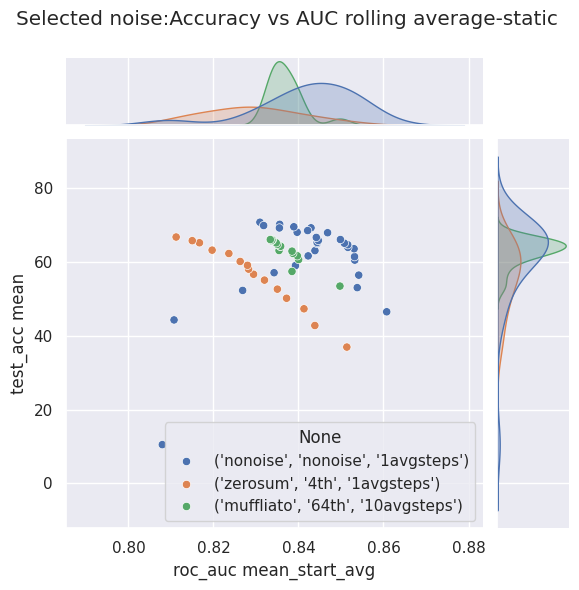

<Figure size 640x480 with 0 Axes>

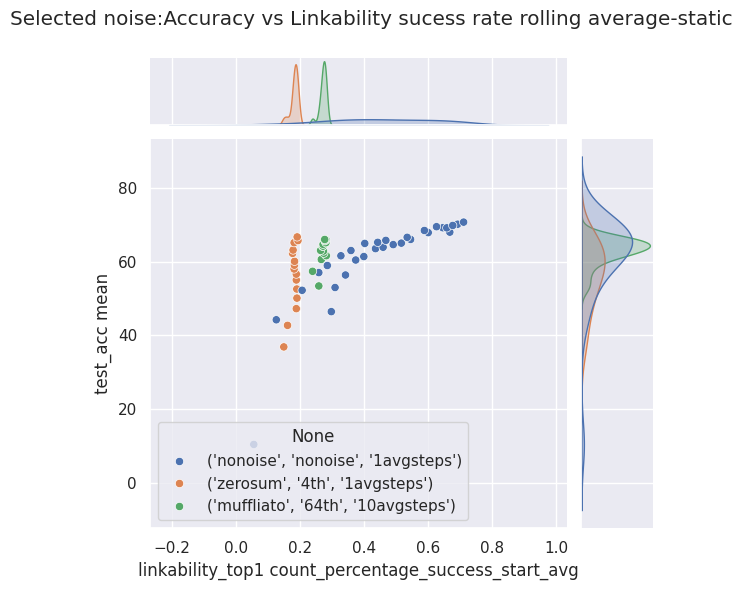

In [ ]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

display_attributes = {
    "hue":["variant","noise_level","avgsteps"],
    "style":["variant","noise_level","avgsteps"],
    "size":["variant","noise_level","avgsteps"], # For some reason having both style and size breaks in this case.
    "col":"topology_type",
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)



utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Accuracy of Zerosum and Muffliato",
    "test_acc mean",
    save_directory=save_directory,
    orderings = ORDERINGS,
)


plt.figure()

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Attack AUC rolling average of Zerosum and Muffliato",
    "roc_auc mean_start_avg",
    save_directory=save_directory,
    orderings = ORDERINGS,
)

plt.figure()

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Linkability attack rolling average ac of Zerosum and Muffliato",
    "linkability_top1 count_percentage_success_start_avg",
    save_directory=save_directory,
    orderings = ORDERINGS,
)

plt.figure()

#Needs to only have hue since we can't have other attributes in jointplots
display_attributes = {
    "hue":["variant","noise_level","avgsteps"],
}

zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)
print("-"*40)


utils.scatter_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Accuracy vs AUC rolling average-static",
    "roc_auc mean_start_avg",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)
plt.figure()
utils.scatter_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Accuracy vs Linkability sucess rate rolling average-static",
    "linkability_top1 count_percentage_success_start_avg",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

In [ ]:
last_expe = list(formatted_data.keys())[-1]
print(formatted_data[last_expe]["noise_level"])

iteration
1        nonoise
100      nonoise
200      nonoise
300      nonoise
400      nonoise
          ...   
9300     nonoise
9500     nonoise
9700     nonoise
9900     nonoise
10000    nonoise
Name: noise_level, Length: 81, dtype: object
